In [9]:
import scipy.stats as ss
import pandas as pd
import numpy as np
data = pd.read_csv('../data/ift_data/ift_data_with_tp_classifications.csv')

The Mann-Whitney test is a non-parametric test for a difference in distribution between two datasets.

In [10]:
data_tp = data.loc[data.TP]
data_fp = data.loc[~data.TP]
print('TP: ', len(data_tp), 'FP: ', len(data_fp))

TP:  84 FP:  348


This initial dataset contains 84 identified true positives and 348 false positives. We are testing 8 variables as candidate parameters for a filter function. A prerequisite for use in the filter is that there is a difference in the distribution of the variable between true positive and false positives. If not, it isn't much use in a filter. We use a conservative adjustment for multiple hypothesis testing by dividing the threshold p-value by the number of variables being tested. 

In [11]:
variables = ['circularity', 'solidity',
             'tc_channel0', 'tc_channel1', 'tc_channel2',
             'fc_channel0', 'fc_channel1', 'fc_channel2']
p_threshold = 0.05/len(variables)

In [12]:
results = {}
for var in variables:
    results[var] = {}
    u, p = ss.mannwhitneyu(data_tp[var], data_fp[var])
    results[var]['u'] = u
    results[var]['p'] = p
    results[var]['sig'] = p < p_threshold
    results[var]['del_median'] = np.round(data_tp[var].median() - data_fp[var].median(), 2)


In [13]:
results = pd.DataFrame(results).T
results

,u,p,sig,del_median
circularity,20731.5,0.0,True,0.15
solidity,21438.0,0.0,True,0.04
tc_channel0,20157.0,0.0,True,15.04
tc_channel1,20577.0,0.0,True,17.29
tc_channel2,20472.0,0.0,True,20.24
fc_channel0,21274.0,0.0,True,14.11
fc_channel1,20885.0,0.0,True,16.91
fc_channel2,7990.0,0.0,True,-94.55


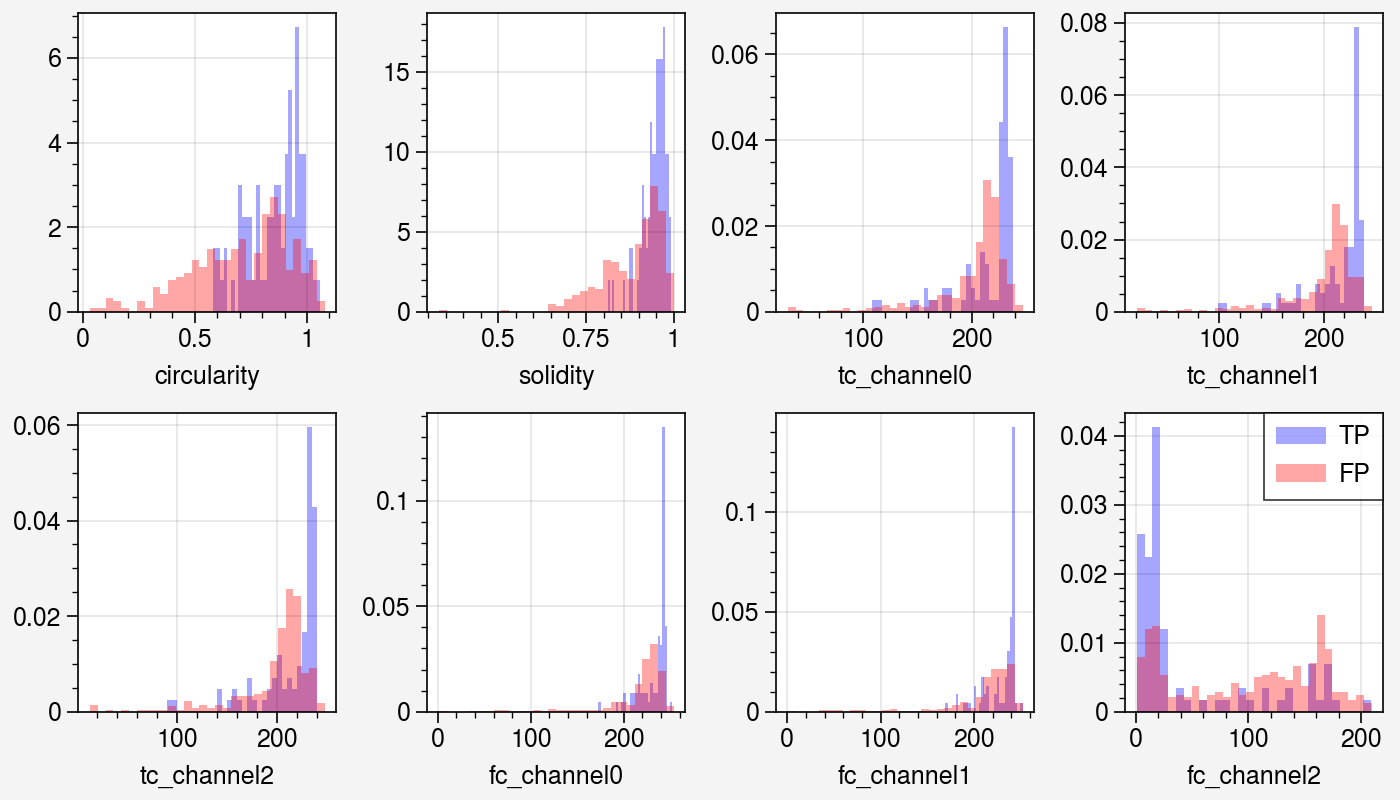

In [17]:
import proplot as pplt
fig, axs = pplt.subplots(width=7, height=4, 
                        nrows=2, ncols=4, share=False)
for var, ax in zip(variables, axs):
    ax.hist(data_tp[var], bins=30, color='b', alpha=0.35, density=True, label='TP')
    ax.hist(data_fp[var], bins=30, color='r', alpha=0.35, density=True, label='FP')
ax.legend(loc='ur', ncols=1)

In [23]:
ax.heatmap?

Signature: ax.heatmap(*args, aspect=None, **kwargs)
Docstring:
Plot grid boxes with formatting suitable for heatmaps. Ensures square grid
boxes, adds major ticks to the center of each grid box, disables minor
ticks and gridlines, and sets :rcraw:`cmap.discrete` to ``False`` by default.

Parameters
----------
*args : z or x, y, z
    The data passed as positional or keyword arguments. Interpreted as follows:

    * If only `z` coordinates are passed, try to infer the `x` and `y` coordinates
      from the `~pandas.DataFrame` indices and columns or the `~xarray.DataArray`
      coordinates. Otherwise, the `y` coordinates are ``np.arange(0, y.shape[0])``
      and the `x` coordinates are ``np.arange(0, y.shape[1])``.
    * For ``pcolor`` and ``pcolormesh``, calculate coordinate *edges* using
      `~proplot.utils.edges` or `~proplot.utils.edges2d` if *centers* were provided.
      For all other methods, calculate coordinate *centers* if *edges* were provided.
    * If the `x` or `y` coord

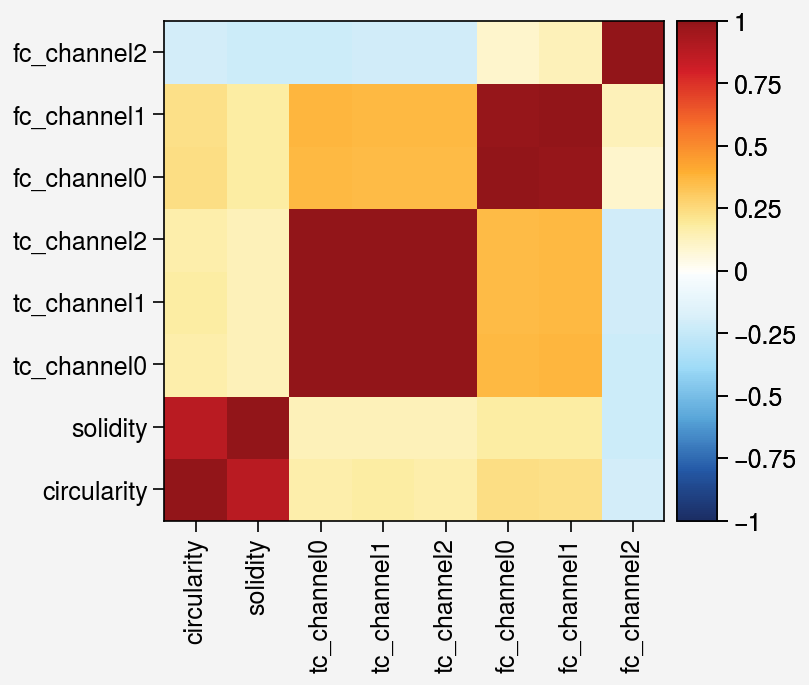

In [24]:
fig, ax = pplt.subplots()
ax.heatmap(data.corr().loc[variables, variables].round(2), vmin=-1, vmax=1, cmap='coldhot', colorbar='r')
ax.format(xrotation=90)

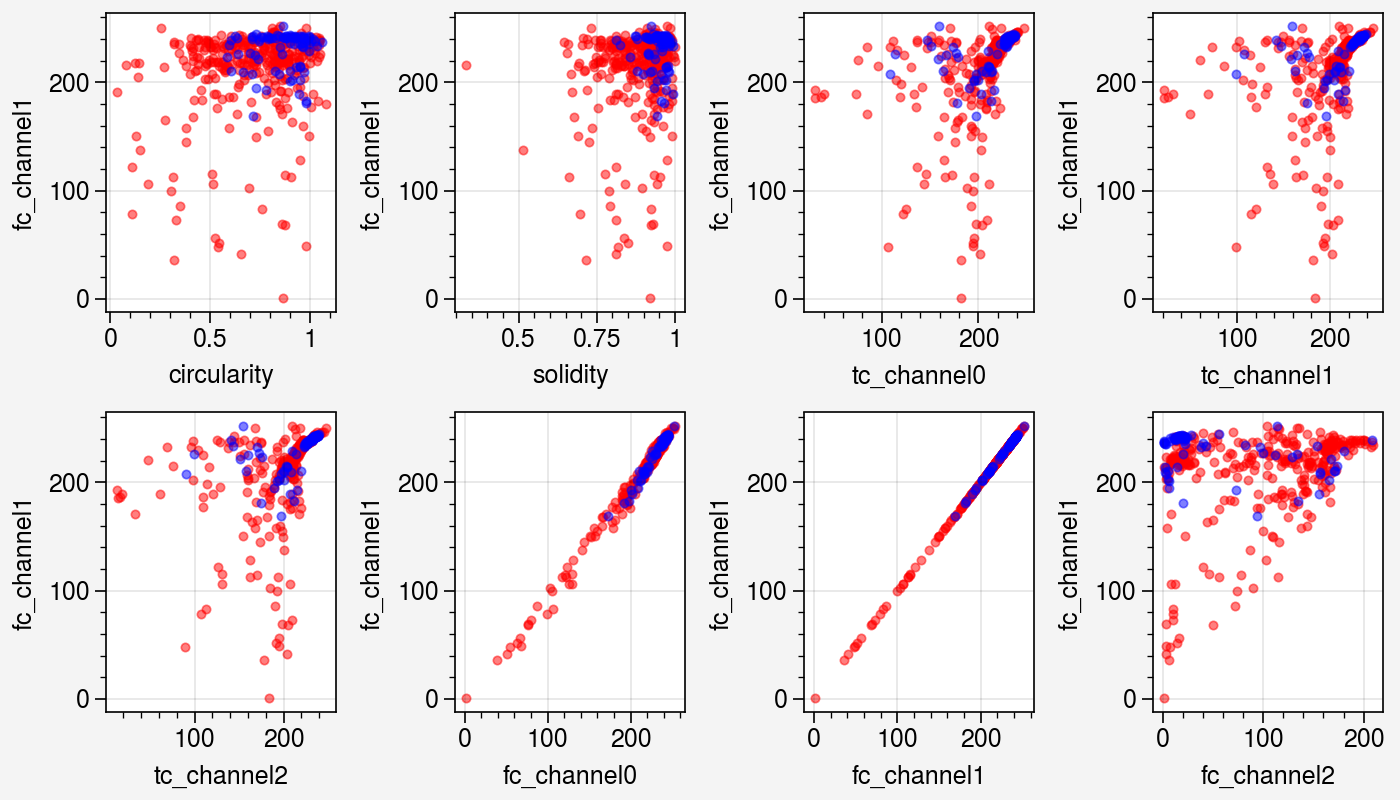

In [46]:
import proplot as pplt
fig, axs = pplt.subplots(width=7, height=4, 
                        nrows=2, ncols=4, share=False)
comp_var = 'fc_channel1'
for var, ax in zip(variables, axs):
    ax.scatter(data_fp[var], data_fp[comp_var], color='r', m='.', alpha=0.5)
    ax.scatter(data_tp[var], data_tp[comp_var], color='b', m='.', alpha=0.5)    

# Logistic regression
Logistic regression in machine learning is commonly used as a classifier. We wish to assign probabilities to candidate floes to determine if they are true positives or false positives. We use two geometric quantities - circularity and solidity - and we use the pixel brightness in the six available channels (three each from the true color and false color images). The colors are likely not independent. So there is a subset of the color channels that will be useful. E.g., FC channels 0 and 1 are 99% correlated, as are TC channels 0 and 1.

We use the implementation of logistic regression in scikit-learn (citation), an open-source machine learning library for Python. This implementation uses a regularization term. The hyperparameters . Defaults used for the regularization constants (Cs=10), we set cv to 3-fold, and we set the score using the sklearn.metrics.f1_score (can also use fbeta_score). For the solver, we use 'liblinear', as that is recommended for small datasets.

In [25]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [26]:
# Scale the pixel brightness from 0 to 1
data_scaled = data.copy()
for var in variables:
    if ('tc' in var) | ('fc' in var):
        data_scaled[var] = data_scaled[var]/255
X = data_scaled.loc[:, variables].to_numpy()
y = data_scaled['TP'].to_numpy()

In [27]:
# Select 1/3 of the data for use in the testing step
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3)
# Can stratify by region if eventually we get enough samples for that

In [44]:
clf = LogisticRegressionCV(Cs=10,
                     solver='lbfgs',
                     scoring='f1',
                     penalty='l2',
                     cv=10,
                     random_state=5).fit(X_train, y_train)

In [45]:
data['PredictedTP'] = clf.predict(X)

In [46]:
clf.score(X_test, y_test)

0.5217391304347826

In [47]:
clf.coef_

array([[  0.69033978,   8.90238632, -42.02160219,  28.45851259,
          8.22173632,   8.47348716,   3.13653698,  -3.32344173]])

In [48]:
data_scaled.loc[:, variables].max()

circularity    1.078932
solidity       1.000000
tc_channel0    0.968178
tc_channel1    0.964856
tc_channel2    0.971501
fc_channel0    0.994150
fc_channel1    0.987810
fc_channel2    0.820015
dtype: float64

In [49]:
data['ProbabilityTP'] = clf.decision_function(X)

In [50]:
from sklearn.calibration import CalibrationDisplay

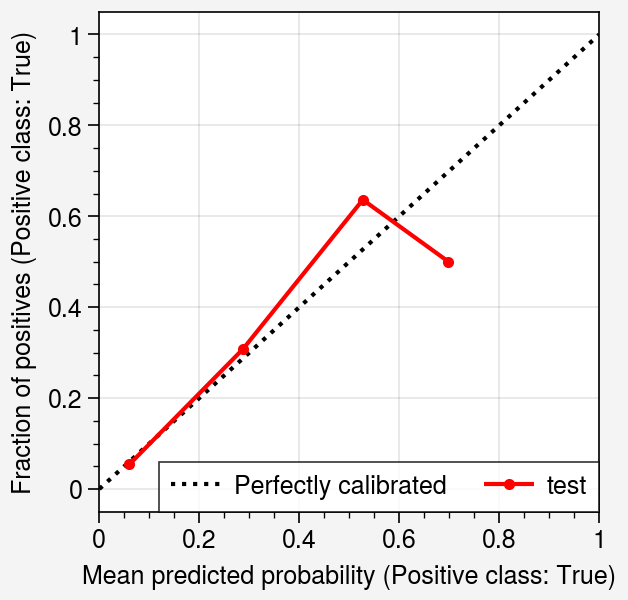

In [51]:
fig, ax = pplt.subplots()
display = CalibrationDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    n_bins=5,
    name='test',
    ax=ax,
    color='r',
    marker='.',
)

# Questions

This is the first time I've used logistic regression outside of possibly using it in a stats class some time ago. It is important that we are careful in our use of statistical tests and regression models so that we are avoiding common pitfalls and using the data as best we can. Some key questions:
1. How do we describe the confidence we have in the classifier model?
2. How should we interpret the calibration curve? If I'm understanding it right, we need to be able to have enough measurements in each predicted probability bin to make an estimate. Above the curve means that we are being overly conservative, and have therefore a higher false negative rate, and below the curve means that we have a higher false positive rate. (I think)
3. How do we choose the appropriate variables for the classifier? We have lots of choices, and there's a lot of values that are correlated with each other. How do we choose the right variables to use?